## 타이타닉 생존자 예측
목적: Build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).
- 즉, 탑승자 관련 데이터를 기반으로 생존 여부를 예측하고 추정하는 모델을 만드는 것

## 분석 순서
1. 데이터 로딩 & 구조 살펴보기
2. 데이터 전처리
3. EDA
4. 학습/테스트 데이터 세트 분리
5. 단순 모델 학습 및 예측 수행
6. 교차 검증을 통해 최적 하이퍼파라미터 및 모델 도출
7. 최종 예측 및 평가 수행

### 1. 데이터 로딩 & 구조 살펴보기

In [10]:
# 필요 모듈을 불러오고
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# titanic 데이터셋을 데이터 프레임으로 불러온다
titanic_df = pd.read_csv('./titanic_train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


각 컬럼에 대한 설명은 아래와 같다
- PassengerId: 
- Survived: 생존여부. 0은 사망, 1은 생존
- Pclass: 티겟 등급. 1=1st, 2=2nd, 3=3rd
- Name: 탑승자 성명
- Sex: 탑승자 성별
- Age: 탑승자 나이. xx.5 형태의 나이인 경우 추정값
- SibSp: 함께 탑승한 배우자/형제자매 인원 수
- Parch: 함께 탑승한 부모/자식 인원 수
- Ticket: 티켓 번호
- Fare: 지불한 요금
- Cabin: 선실 번호
- Embarked: 승선 항구. C=Cherbourg, Q=Queenstown, S=Southampton

In [24]:
print("### 데이터프레임 정보 한 눈에 보기 ###\n")
titanic_df.info()
titanic_df.shape

# 총 891개의 레코드가 있고 12개의 컬럼이 있음을 확인할 수 있다
# 추가적으로 Age, Cabin, Embarked 컬럼은 null 값이 존재한다는 것도 확인 가능

### 데이터프레임 정보 한 눈에 보기 ###

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(891, 12)

In [28]:
# describe를 통해 기본 통계 정보를 확인할 수 있다
# 이때 describe는 수치형 데이터 타입을 가진 컬럼에 대해서만 결과를 반환한다
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 2. 데이터 전처리

**NULL 데이터 처리하기**

In [32]:
# Age, Cabin, Embarked에 Null 값이 존재한다
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [41]:
# 나이는 평균 값으로 대체해준다
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)

# 선실 번호와 승선 항구의 Null 값들은 'N'으로 대체해준다
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)

In [43]:
# isnull()에 sum()을 2번 수행해서 모든 컬럼의 null 값 개수의 합이 0임을 확인한다
titanic_df.isnull().sum().sum()

0

### 3. EDA

In [52]:
# 데이터 타입의 값이 object인 컬럼만 모아서 보면 아래와 같다
titanic_df.dtypes[titanic_df.dtypes == 'object'].index.tolist()

# 이렇게 하는 이유는 아마 데이터 타입이 object인 것들이 주로 dimension이 되기 때문일까?

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [62]:
# object 타입인 컬럼 중 일부 컬럼의 값 분포를 value_counts()로 살펴본다
print("Sex 값 분포\n", titanic_df['Sex'].value_counts())
print("\nCabin 값 분포\n", titanic_df['Cabin'].value_counts())
print("\nEmbarked 값 분포\n", titanic_df['Embarked'].value_counts())

Sex 값 분포
 Sex
male      577
female    314
Name: count, dtype: int64

Cabin 값 분포
 Cabin
N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: count, Length: 148, dtype: int64

Embarked 값 분포
 Embarked
S    644
C    168
Q     77
N      2
Name: count, dtype: int64


In [63]:
# Cabin의 카디널리티 값이 너무 높아 첫번째 문자열 값으로 대체해본다
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].value_counts())

Cabin
N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


In [65]:
# 성별과 생존 여부를 groupby해서 각 성별별로 얼마나 생존했는지 살펴본다
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

<Axes: xlabel='Sex', ylabel='Survived'>

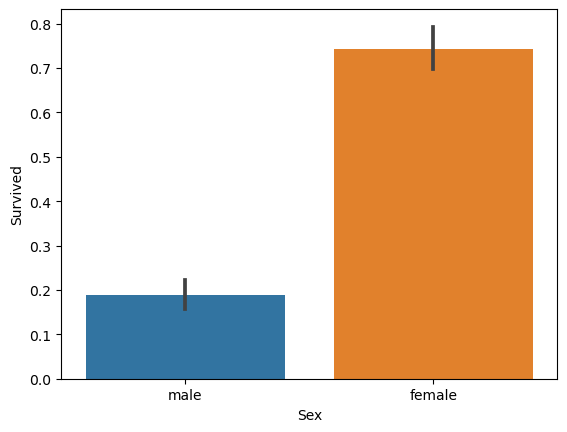

In [67]:
# seaborn으로 시각화를 해보면 아래와 같다
# 여기서 y축 값은 survived 값의 평균이다 (=생존율)
sns.barplot(x='Sex', y='Survived', data=titanic_df)

<Axes: xlabel='Pclass', ylabel='Survived'>

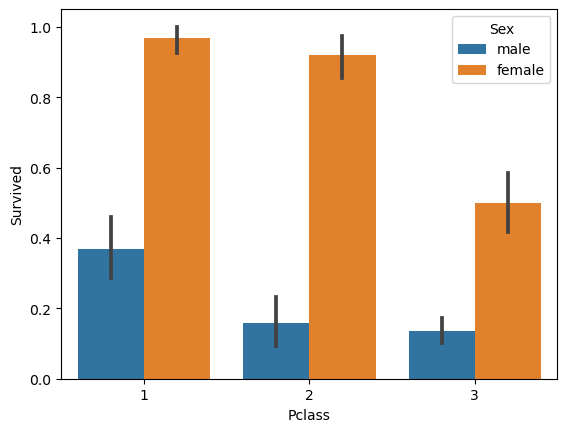

In [69]:
# 객실 등급별 & 성별에 따른 생존율은 아래와 같다
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

<Axes: xlabel='Age_cat', ylabel='Survived'>

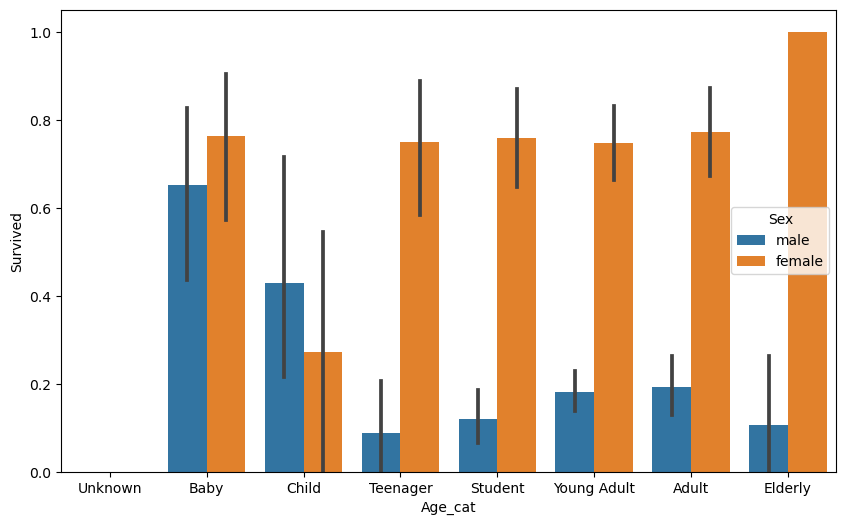

In [72]:
# Age컬럼 값을 카테고리형으로 변경하기 위해서 아래와 같이 함수를 정의
def get_category(age):
    cat = ''
    if age <= -1: cat = 'unknown'
    elif age <= 5: cat = 'Baby'
    elif age <= 12: cat = 'Child'
    elif age <= 18: cat = 'Teenager'
    elif age <= 25: cat = 'Student'
    elif age <= 35: cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else: cat = 'Elderly'
        
    return cat

# 막대 그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10, 6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 적용
# 그 값으로 새로운 컬럼 Age_cat 생성
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x: get_category(x))

sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)

### 4. 학습/테스트 데이터 세트 분리 및 전처리

**데이터 전처리 절차를 함수로 먼저 정리**

In [73]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    return df

# 머신러닝에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df
    
# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 위 3개 데이터 전처리 함수를 차례대로 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [84]:
# 원본 데이터 재로딩
titanic_df = pd.read_csv('./titanic_train.csv')

# 먼저 feature/target 분리
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(['Survived'], axis=1, inplace=False)

# 위에서 정의한 전처리 함수 transform_features 적용
X_titanic_df = transform_features(X_titanic_df)
X_titanic_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


In [87]:
# 데이터 셋을 학습용과 테스트용으로 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(712, 8) (179, 8) (712,) (179,)


### 5. 단순 모델 학습 및 예측 수행

In [107]:
# Classifier 모델 임포트
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, 랜덤포레스트, 로지스틱회귀 Classifier 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression(solver='liblinear')

# Decision Tree Classifier 모델 학습, 예측, 정확도 평가
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
print('Decision Tree Classifier 모델 정확도:', np.round(accuracy_score(y_test, pred), 4))

# Random Forest Classifier 모델 학습, 예측, 정확도 평가
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print('Random Forest Classifier 모델 정확도:', np.round(accuracy_score(y_test, pred), 4))

# Logistic Regression 모델 학습, 예측, 정확도 평가
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
print('Logistic Regression 모델 정확도:', np.round(accuracy_score(y_test, pred), 4))

Decision Tree Classifier 모델 정확도: 0.7877
Random Forest Classifier 모델 정확도: 0.8547
Logistic Regression 모델 정확도: 0.8659


### 6. 교차 검증을 통해 최적 하이퍼파라미터 및 모델 도출

**K-Fold 교차검증 해보기**

In [113]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
    # folds의 default값은 5. 입력된 값 or 5개를 인자로 KFold 객체 생성
    kfold = KFold(n_splits=folds)
    # 폴드 수만큼 예측 정확도를 저장하기 위한 리스트 scores 생성
    scores = []
    
    #KFold 교차검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # 데이터셋을 학습과 검증 데이터 셋으로 index를 활용해 분리해준다
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        
        # Classifier 학습, 예측, 평가 수행
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = np.round(accuracy_score(y_test, predictions), 4)
        scores.append(accuracy)
        print(f"{iter_count + 1}번째 교차검증 정확도: {accuracy}")
    
    # 5번의 교차검증 정확도의 평균을 구한다
    mean_score = np.mean(scores)
    print(f"K-Fold 교차검증 평균 정확도: {mean_score}")

# 함수 호출하고 위에서 생성한 dt_clf를 넣어준다
exec_kfold(dt_clf)

1번째 교차검증 정확도: 0.7542
2번째 교차검증 정확도: 0.7809
3번째 교차검증 정확도: 0.7865
4번째 교차검증 정확도: 0.7697
5번째 교차검증 정확도: 0.8202
K-Fold 교차검증 평균 정확도: 0.7823


**Stratified K-Fold 교차검증 해보기**

In [118]:
# Stratified K-Fold를 손쉽게 수행할 수 있는 cross_val_score함수 이용
from sklearn.model_selection import cross_val_score

# cv에 넣는 값이 K-Fold의 K 값이다
scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    accuracy = np.round(accuracy, 4)
    print(f"{iter_count+1}번째 교차검증 정확도: {accuracy}")
print(f"Stratified K-Fold 교차검증 평균 정확도: {np.round(np.mean(scores), 4)}")

1번째 교차검증 정확도: 0.743
2번째 교차검증 정확도: 0.7753
3번째 교차검증 정확도: 0.7921
4번째 교차검증 정확도: 0.7865
5번째 교차검증 정확도: 0.8427
Stratified K-Fold 교차검증 평균 정확도: 0.7879


**GridSearchCV로 Stratified K-Fold 교차검증 & 최적 하이퍼파라미터 도출**

In [119]:
from sklearn.model_selection import GridSearchCV


In [128]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터명과 후보 값을 딕셔너리 형태로 저장한다
parameters = {
    "max_depth": [2, 3, 5, 10],
    "min_samples_leaf": [1, 5, 8],
    "min_samples_split": [2, 3, 5]
}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring="accuracy", refit=True, cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearchCV 최적 하이퍼 파라미터:", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도:", np.round(grid_dclf.best_score_, 4))

# 하이퍼 파라미터 튜닝을 통해 위 Stratified K-Fold의 정확도보다 향상시킬 수 있었다

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992


### 7. 최종 예측 및 평가 수행

위 GridSearchCV에서 도출된 최적 하이퍼 파라미터로 학습된 Estimator가 best_estimator_에 저장되어 있다. 이를 best_dclf로 저장해서 최종 예측을 테스트 데이터 셋에 대해 수행하고 모델의 정확도를 평가한다.

In [129]:
best_dclf = grid_dclf.best_estimator_

pred = best_dclf.predict(X_test)
print("최종 모델의 예측 정확도:", np.round(accuracy_score(y_test, pred), 4))

최종 모델의 예측 정확도: 0.8715
